## Sales Forecasting using Walmart data set.

<img width="450" align="left" src="https://miro.medium.com/max/2760/1*gsUixexI9DsFfKsS-ZZqng.png">

Sales forecast is an indicator of a product quantity that is likely to be sold in a time period in a specified market at given price. In other words, accurate sales forecasting enables a company to produce the required quantity at the right time in order to meet the future demand. [1]

In this project, I used a machine learning approach to forecast sales for each departemnt of each of 45 Walmart stores based on [Walmart data set](https://github.com/apadhye90/data-mining/tree/master/Kaggle%20Dataset) [2]


> [1] [Sales Forecasting: Meaning, Importance and Methods](https://www.businessmanagementideas.com/sales/forecasting-sales/sales-forecasting-meaning-importance-and-methods/7122)
<br>
[2] [Walmart Recruiting - Store Sales Forecasting: Overview](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting)

<br>

### Table of Contents

<br>

### General Setup
___

In [1]:
# Dataframes.
import pandas as pd

# Numerical arrays.
import numpy as np

# Stationarity
from statsmodels.tsa.stattools import adfuller

# Predistions
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import warnings

# Plotting.
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

%matplotlib inline

In [2]:
# Change style and size of plots
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["figure.titlesize"] = 15

<br>

### Exploratory Data Analysis.
___

The data set consists of 4 csv files: stores, train, test, features. [3] First, I will analyse them separately. [4]

> [3] [Walmart Recruiting - Store Sales Forecasting: Data Description](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data)
<br>
[4] [Exploratory Data Analysis(EDA): Python](https://towardsdatascience.com/exploratory-data-analysis-eda-python-87178e35b14)

<br>

#### Stores.

_1. Load the file._

In [3]:
# Load the stores.csv without an index.
stores = pd.read_csv("Walmart Data Set/stores.csv", header=0)

# Display the dafaframe
stores.head()

,Store,Type,Size,Store A,Store B,Store C
0,1,A,151315,219622.0000,140167.0000,42988.00000
1,2,A,202307,39690.0000,34875.0000,39690.00000
2,4,A,205863,177247.7273,101190.7059,40541.66667
3,6,A,202505,NaN,NaN,NaN
4,8,A,155078,NaN,NaN,NaN


In [4]:
# Display the dafaframe
stores.tail()

,Store,Type,Size,Store A,Store B,Store C
40,37,C,39910,NaN,NaN,NaN
41,38,C,39690,NaN,NaN,NaN
42,42,C,39690,NaN,NaN,NaN
43,43,C,41062,NaN,NaN,NaN
44,44,C,39910,NaN,NaN,NaN


In [5]:
stores.describe()

,Store,Size,Store A,Store B,Store C
count,45.000000,45.000000,3.000000,3.000000,3.000000
mean,23.000000,130287.600000,145519.909100,92077.568633,41073.222223
std,13.133926,63825.271991,94068.443124,53234.277201,1712.049789
min,1.000000,34875.000000,39690.000000,34875.000000,39690.000000
25%,12.000000,70713.000000,108468.863650,68032.852950,40115.833335
50%,23.000000,126512.000000,177247.727300,101190.705900,40541.666670
75%,34.000000,202307.000000,198434.863650,120678.852950,41764.833335
max,45.000000,219622.000000,219622.000000,140167.000000,42988.000000


The stores file consist of information about 45 stores, including the type and size of each. We can observe that there are mainly empty values in the columns Store A, Store B and Store C. 



<br>

_2. Data cleaning._

The first step to cleansing the data is by checking it for empty values.

In [6]:
# Check for empty values.
stores.isnull().sum()

Store       0
Type        0
Size        0
Store A    42
Store B    42
Store C    42
dtype: int64

The above confirms that only the last three columns have the empty values. Since they do not provide enough information that could be valuable in the sales forecasting, they will be removed.

In [7]:
# Remove columns with empty values.
cleaned_stores = stores.drop(['Store A','Store B','Store C'], axis=1)

# Check for empty values again.
cleaned_stores.isnull().sum()

Store    0
Type     0
Size     0
dtype: int64

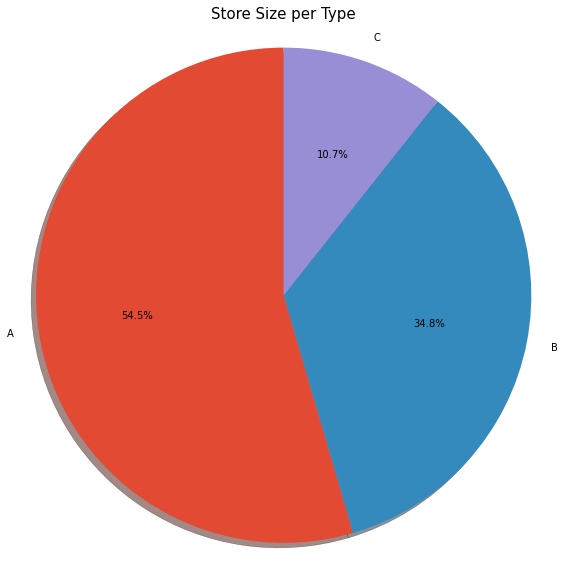

In [8]:
# Calculate maximum values of each store type and set as pie sizes
sizes = cleaned_stores.groupby('Type').max().Size.values
labels = cleaned_stores.groupby('Type').max().index

# Create a figure and axis, set a title.
fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle("Store Size per Type")

# Build a pie plot.
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal') 

# Show the plot.
plt.tight_layout()
plt.show()

<br>

#### Train.


In [9]:
# Load the train.csv without an index.
train = pd.read_csv("Walmart Data Set/train.csv", header=0, parse_dates=True, index_col="Date")

# Display the dafaframe.
train.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [10]:
# Display the dafaframe.
train.tail()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2012-09-28,45,98,508.37,False
2012-10-05,45,98,628.10,False
2012-10-12,45,98,1061.02,False
2012-10-19,45,98,760.01,False
2012-10-26,45,98,1076.80,False


In [11]:
train.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


The above dataframe contains weekly sales for 45 stores per department for the period from 2010-02-05 to 2012-10-26. We can see that altogether there are 99 departments. It also includes the department number and whether the week is a special holiday week.

In [12]:
# Check for empty values.
train.isnull().sum()

Store           0
Dept            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

The dataframe doesn't have any empty values.

In [13]:
depts = train.groupby("Store").Dept.nunique()
print(f"Maximum Departments: {np.max(depts)}\nMinimum Departments: {np.min(depts)}")

Maximum Departments: 79
Minimum Departments: 61


It is clear that the stores have different distribution of departments.

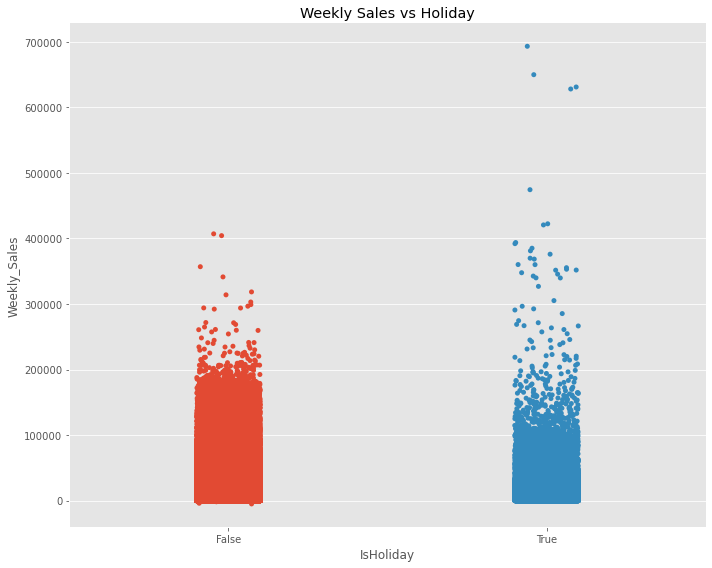

In [14]:
# Plot the data by year
g = sns.catplot(x='IsHoliday', y='Weekly_Sales', data=train)
g.fig.set_size_inches(10,8)

# Show the plot.
plt.title("Weekly Sales vs Holiday")
plt.tight_layout()
plt.show()

<br> 

#### Test.


In [15]:
# Load the train.csv without an index.
test = pd.read_csv("Walmart Data Set/test.csv", header=0, parse_dates=True, index_col="Date")

# Display the dafaframe.
test.head()

,Store,Dept,IsHoliday
Date,,,
2012-11-02,1,1,False
2012-11-09,1,1,False
2012-11-16,1,1,False
2012-11-23,1,1,True
2012-11-30,1,1,False


In [16]:
test.tail()

,Store,Dept,IsHoliday
Date,,,
2013-06-28,45,98,False
2013-07-05,45,98,False
2013-07-12,45,98,False
2013-07-19,45,98,False
2013-07-26,45,98,False


<br>

#### Features.

In [17]:
# Load the features.csv without an index.
features = pd.read_csv("Walmart Data Set/features.csv", header=0, parse_dates=True, index_col="Date")

# Display the dafaframe
features.head()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
Date,,,,,,,,,,,
2010-02-05,1,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
2010-02-12,1,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2010-02-19,1,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
2010-02-26,1,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
2010-03-05,1,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [18]:
# Display the dafaframe
features.tail()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
Date,,,,,,,,,,,
2013-06-28,45,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
2013-07-05,45,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
2013-07-12,45,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
2013-07-19,45,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
2013-07-26,45,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


The features file contains additional data related to the store, department, and regional activity for the given dates. MarkDown columns are related to promotional markdowns that Walmart is running. 

In [19]:
features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [20]:
# Check for empty values.
features.isnull().sum()

Store              0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [21]:
features.loc['2011-11-1': '2011-11-30']

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
Date,,,,,,,,,,,
2011-11-04,1,54.98,3.332,NaN,NaN,NaN,NaN,NaN,217.837382,7.866,False
2011-11-11,1,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,False
2011-11-18,1,62.25,3.308,6074.12,254.39,51.98,427.39,5988.57,218.220509,7.866,False
2011-11-25,1,60.14,3.236,410.31,98.00,55805.51,8.00,554.92,218.467621,7.866,True
2011-11-04,2,55.53,3.332,NaN,NaN,NaN,NaN,NaN,217.485360,7.441,False
...,...,...,...,...,...,...,...,...,...,...,...
2011-11-25,44,38.89,3.445,NaN,NaN,NaN,NaN,256.45,129.836400,6.078,True
2011-11-04,45,43.92,3.551,NaN,NaN,NaN,NaN,NaN,187.970363,8.523,False
2011-11-11,45,47.65,3.530,23052.25,5449.62,189.24,3355.69,3864.60,188.063234,8.523,False


We can see that MarkDowns appear from 11.11.2011.

In [22]:
features = features.loc['2011-11-11': '2013-07-26']

In [23]:
#features = features.dropna(subset=["MarkDown1"])
features

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
Date,,,,,,,,,,,
2011-11-11,1,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,False
2011-11-18,1,62.25,3.308,6074.12,254.39,51.98,427.39,5988.57,218.220509,7.866,False
2011-11-25,1,60.14,3.236,410.31,98.00,55805.51,8.00,554.92,218.467621,7.866,True
2011-12-02,1,48.91,3.172,5629.51,68.00,1398.11,2084.64,20475.32,218.714733,7.866,False
2011-12-09,1,43.93,3.158,4640.65,19.00,105.02,3639.42,14461.82,218.961846,7.866,False
...,...,...,...,...,...,...,...,...,...,...,...
2013-06-28,45,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
2013-07-05,45,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
2013-07-12,45,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False


In [24]:
def date_format(ax, int):
    # Make the x axis display well.
    weeks = mdates.DayLocator(int)
    h_fmt = mdates.DateFormatter('%d-%m-%Y')

    # Tick ax axis.
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_major_formatter(h_fmt)

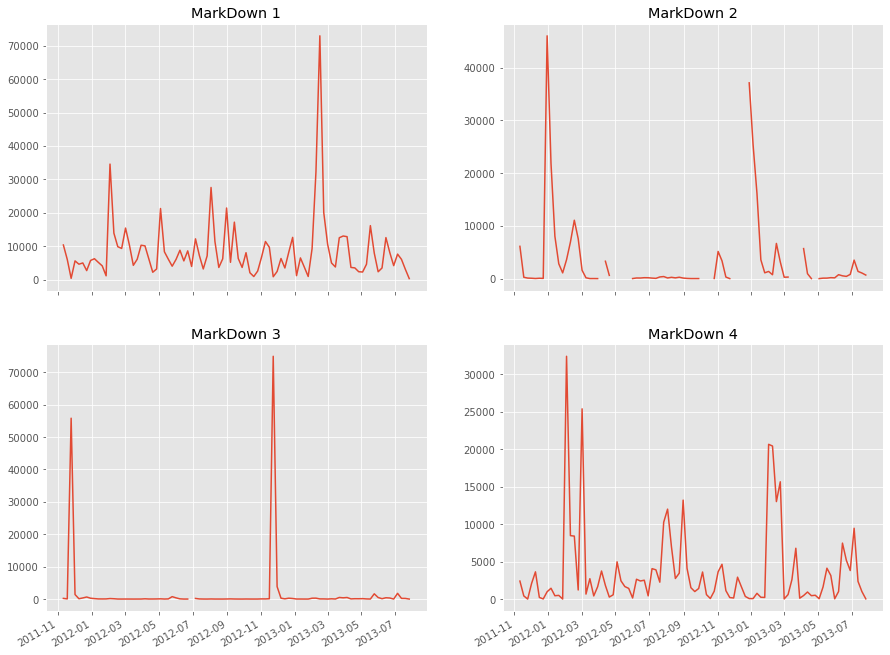

In [25]:
# Calculate mean of columns in features.
temp = features[features["Store"]==1].groupby(["Date"]).mean()

# Create a figure and a set of axis
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2, figsize=(15,12))

# Date Format.
fig.autofmt_xdate()

# Plot the data.
ax1.plot(temp.MarkDown1)
ax1.title.set_text("MarkDown 1")
ax2.plot(temp.MarkDown2)
ax2.title.set_text("MarkDown 2")
ax3.plot(temp.MarkDown3)
ax3.title.set_text("MarkDown 3")
ax4.plot(temp.MarkDown4)
ax4.title.set_text("MarkDown 4")

# Show the plots.
plt.show()

In [26]:
# Fill the missing values.
features["MarkDown1"].fillna(method="ffill", inplace=True)
features["MarkDown2"].fillna(method="ffill", inplace=True)
features["MarkDown3"].fillna(method="bfill", inplace=True)
features["MarkDown4"].fillna(method="ffill", inplace=True)

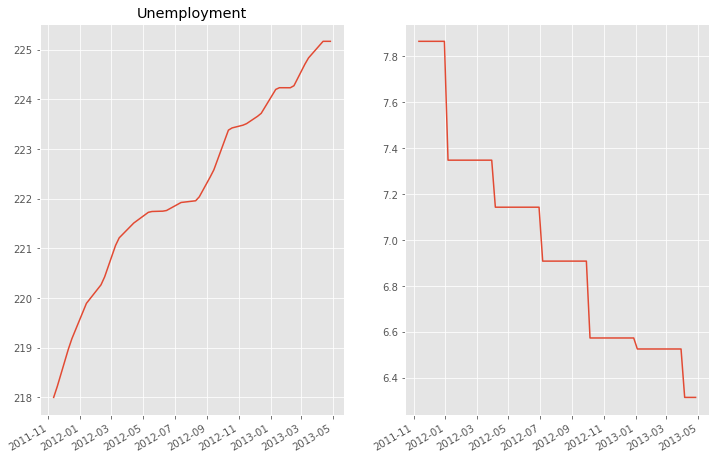

In [27]:
# Create a figure and a set of axis
fig, [ax1,ax2] = plt.subplots(1,2)

# Date Format.
fig.autofmt_xdate()

# Plot the data.
ax1.plot(temp.CPI)
ax1.title.set_text("CPI")
ax2.plot(temp.Unemployment)
ax1.title.set_text("Unemployment")

# Show the plots.
plt.show()

In [28]:
# Filling missing values for CPI and unemployment
features["CPI"].fillna(method="ffill", inplace=True)
features["Unemployment"].fillna(method="ffill", inplace=True)

In [29]:
# Checking for missing values again.
features.isnull().sum()

Store           0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
dtype: int64

In [30]:
# Separate test features from train.
features_train = features.loc['2011-11-11': '2012-10-26'].reset_index()
features_test = features.loc['2012-11-02': '2013-04-19'].reset_index()
features_train.head()

,Date,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,2011-11-11,1,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,False
1,2011-11-18,1,62.25,3.308,6074.12,254.39,51.98,427.39,5988.57,218.220509,7.866,False
2,2011-11-25,1,60.14,3.236,410.31,98.00,55805.51,8.00,554.92,218.467621,7.866,True
3,2011-12-02,1,48.91,3.172,5629.51,68.00,1398.11,2084.64,20475.32,218.714733,7.866,False
4,2011-12-09,1,43.93,3.158,4640.65,19.00,105.02,3639.42,14461.82,218.961846,7.866,False


<br>

### Mergining data sets.
___

In [31]:
# Merge the dataframes into one.
df = train.merge(features_train, on=['Store', 'IsHoliday', 'Date'],how='left').dropna()
df = df.merge(cleaned_stores, on=['Store'], how='left')
df['Date']=pd.to_datetime(df['Date'],infer_datetime_format=True)
df=df.set_index(['Date'])
# Display the new dataframe with a date index.
df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
Date,,,,,,,,,,,,,,,
2011-11-11,1,1,18689.54,False,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,A,151315
2011-11-18,1,1,19050.66,False,62.25,3.308,6074.12,254.39,51.98,427.39,5988.57,218.220509,7.866,A,151315
2011-11-25,1,1,20911.25,True,60.14,3.236,410.31,98.00,55805.51,8.00,554.92,218.467621,7.866,A,151315
2011-12-02,1,1,25293.49,False,48.91,3.172,5629.51,68.00,1398.11,2084.64,20475.32,218.714733,7.866,A,151315
2011-12-09,1,1,33305.92,False,43.93,3.158,4640.65,19.00,105.02,3639.42,14461.82,218.961846,7.866,A,151315


In [32]:
df.tail()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
Date,,,,,,,,,,,,,,,
2012-09-28,45,98,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
2012-10-05,45,98,628.10,False,64.89,3.985,5046.74,20.64,18.82,2253.43,2340.01,192.170412,8.667,B,118221
2012-10-12,45,98,1061.02,False,54.47,4.000,1956.28,20.64,7.89,599.32,3990.54,192.327265,8.667,B,118221
2012-10-19,45,98,760.01,False,56.47,3.969,2004.02,20.64,3.18,437.73,1537.49,192.330854,8.667,B,118221
2012-10-26,45,98,1076.80,False,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,B,118221


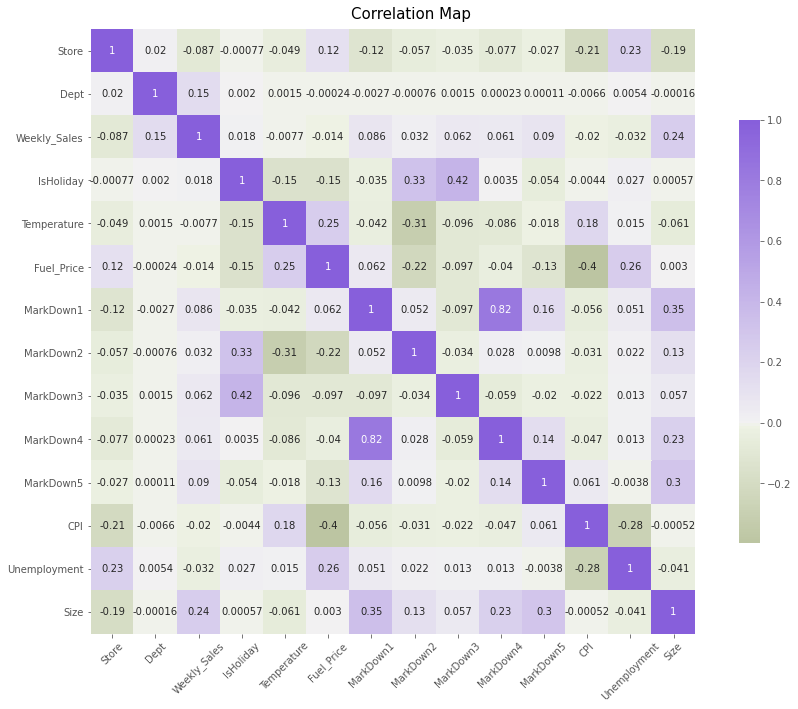

In [33]:
# Create a figure and axis.
fig, ax = plt.subplots(figsize=(13,10))
fig.suptitle("Correlation Map")

# Plot the correlation
corr = df.corr()
cmap = sns.diverging_palette(100, 275, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0, annot=True,square=True,cbar_kws={"shrink": .7}, ax=ax)

# Set a title and rotate x axis 
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot.
plt.show()

The heatmap shows that weekly sales are dependent on:
* Store Size
* Department
* MarkDown5, MarkDown1, MarkDown3, MarkDown4, MarkDown2
* IsHoliday

<br>
    
### Holidays & Markdowns

In [34]:
per_store = df.groupby("Store").agg({"Weekly_Sales": "sum"})
per_store.head()

,Weekly_Sales
Store,
1,8.240240e+07
2,9.971122e+07
3,2.180177e+07
4,1.133677e+08
5,1.722797e+07


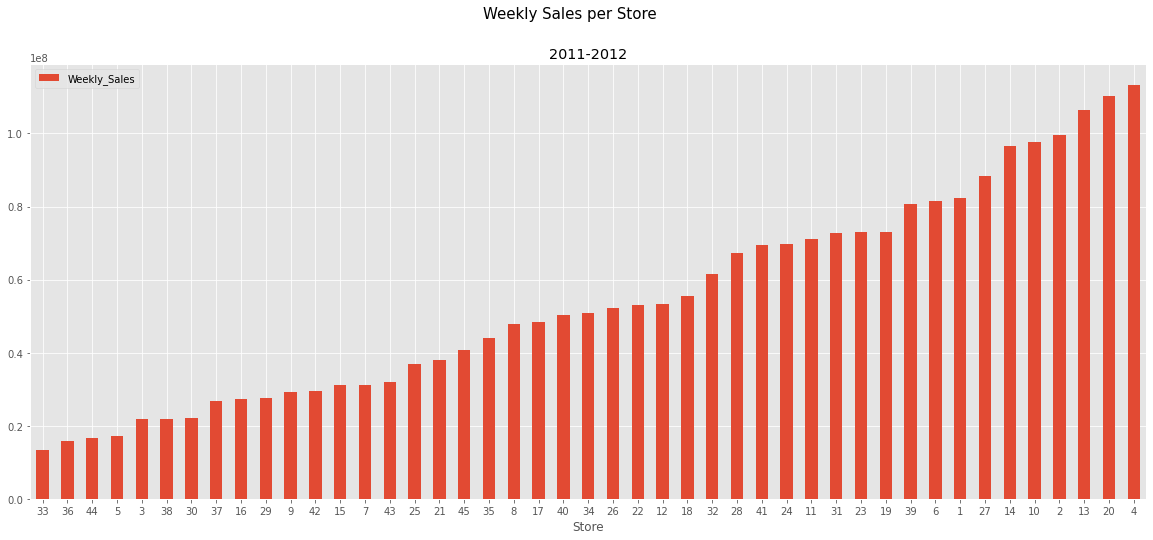

In [35]:
# Create a figure and axis.
fig, ax = plt.subplots(figsize=(20,8))
fig.suptitle("Weekly Sales per Store")

# Plot the data by year
per_store.sort_values("Weekly_Sales").plot.bar(ax=ax)

# Set a title and change rotation of xticks back to 0 
plt.title("2011-2012")
plt.xticks(rotation=0)

# Show the plot.
plt.show()

In [36]:
#sales = pd.DataFrame(df.groupby(["Store", "Dept", "Date"]).Weekly_Sales.sum())
sales = pd.DataFrame(df["Weekly_Sales"])
sales.head()

,Weekly_Sales
Date,
2011-11-11,18689.54
2011-11-18,19050.66
2011-11-25,20911.25
2011-12-02,25293.49
2011-12-09,33305.92


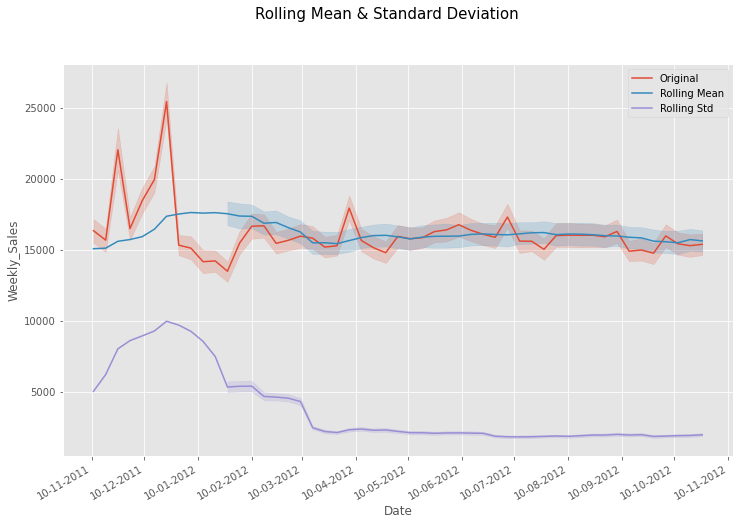

Results of Dickey-Fuller Test:
Test Statistic                    -23.196255
p-value                             0.000000
#Lags Used                         75.000000
Number of Observations Used    151356.000000
Critical Value (1%)                -3.430393
Critical Value (5%)                -2.861559
Critical Value (10%)               -2.566780
dtype: float64


In [37]:
def test_stationarity(ts):
    # Create a figure and axis.
    fig, ax = plt.subplots()
    fig.suptitle('Rolling Mean & Standard Deviation')

    # Date Format.
    date_format(ax,10)
    fig.autofmt_xdate()

    # Determing rolling statistics
    rolmean = ts["Weekly_Sales"].rolling(12).mean()
    rolstd = ts["Weekly_Sales"].rolling(12).std()

    # Plot rolling statistics:
    sns.lineplot(data=ts, x="Date", y="Weekly_Sales", ax=ax, label='Original')
    sns.lineplot(data=ts, x="Date", y=rolmean, ax=ax, label='Rolling Mean')
    sns.lineplot(data=ts, x="Date", y=rolstd, ax=ax, label = 'Rolling Std')

    # Show the plot
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

test_stationarity(sales)

The Test Statistic is approximately -23.2 which is much smaller than the 1% critical value of -3.43 and so we have enough evidence to conclude that unit root does not exist. In other words, the series is stationary.

### ARIMA model.

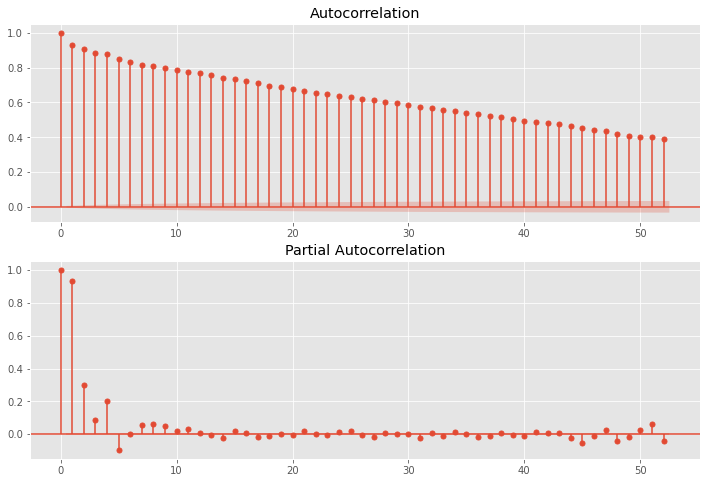

In [38]:
#sales.index = pd.DatetimeIndex(df.index).to_period('W')
# Create a figure and axis.
fig, [ax1,ax2] = plt.subplots(2,1)

# Plot the acf and pacf.
plot_acf(sales, ax=ax1)
plot_pacf(sales, ax=ax2)

# Show the plots.
plt.show()

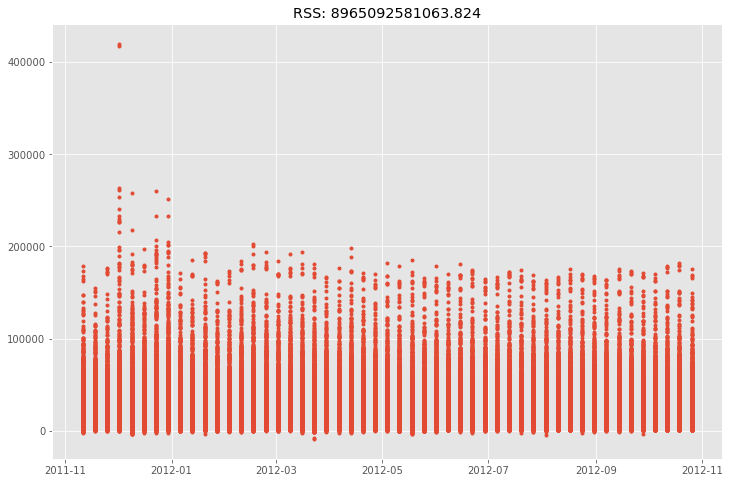

In [49]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    model=ARIMA(sales,order=(10,0,2))
    result=model.fit()
    
    fig, ax = plt.subplots()
    ax.plot(result.fittedvalues,'.')
    
    # RSS error as a title
    plt.title(f'RSS: {sum((result.fittedvalues-df["Weekly_Sales"])**2)}')
    
    # Show the plot
    plt.show()

### Test data.

In [50]:
test_df = test.merge(features_test, on=['Store', 'IsHoliday', 'Date'],how='left')
test_df.index = test_df.Date
test_df = test_df.drop("Date", axis=1)
test_df.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,
2012-11-02,1,1,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573
2012-11-09,1,1,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573
2012-11-16,1,1,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573
2012-11-23,1,1,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573
2012-11-30,1,1,False,52.34,3.207,2460.03,4.17,3838.35,150.57,6966.34,223.610984,6.573


In [52]:
test_df.tail()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,
2013-06-28,45,98,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-07-05,45,98,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-07-12,45,98,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-07-19,45,98,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-07-26,45,98,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
test_df.isnull().sum()

Store               0
Dept                0
IsHoliday           0
Temperature     41108
Fuel_Price      41108
MarkDown1       41108
MarkDown2       41108
MarkDown3       41108
MarkDown4       41108
MarkDown5       41108
CPI             41108
Unemployment    41108
dtype: int64

### References 

> 1.[How to group pandas DataFrame entries by date in a non-unique column](https://stackoverflow.com/questions/11391969/how-to-group-pandas-dataframe-entries-by-date-in-a-non-unique-column)<br>
2. [Date tick labels](https://matplotlib.org/3.1.1/gallery/text_labels_and_annotations/date.html)<br>
3. [Pandas Groupby: Summarising, Aggregating, and Grouping data in Python](https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/#multiple-statistics-per-group)<br>
4. [Augmented Dickey-Fuller Test in Python](http://www.hackdeploy.com/augmented-dickey-fuller-test-in-python/)<br>
5. [A comprehensive beginner’s guide to create a Time Series Forecast (with Codes in Python and R)](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)